In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')



from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization, Add
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm

2024-08-22 05:47:55.457493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 05:47:55.457617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 05:47:55.588502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import shutil
import random
import os
from PIL import Image

# Base folder path
base_folder = "/kaggle/input/synthetic-faces-high-quality-sfhq-part-1/images/images"

# Train and test folder paths
train_folder = "/kaggle/working/train"
test_folder = "/kaggle/working/test"

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get all image filenames
all_images = [f for f in os.listdir(base_folder) if os.path.isfile(os.path.join(base_folder, f))]

# Shuffle the images
random.shuffle(all_images)

# Select images for train and test folders
train_images = all_images[:20000]
test_images = all_images[20000:20500]

# Function to resize and copy images to the destination folder
def resize_and_copy_images(images, dest_folder, size=(128, 128)):
    for image in images:
        src = os.path.join(base_folder, image)
        dst = os.path.join(dest_folder, image)
        with Image.open(src) as img:
            img = img.resize(size)  # Resize the image
            img.save(dst)  # Save the resized image

# Resize and copy images to train and test folders
resize_and_copy_images(train_images, train_folder)
resize_and_copy_images(test_images, test_folder)

print("Images have been successfully resized and copied to train and test folders.")


Images have been successfully resized and copied to train and test folders.


In [3]:
import cv2
import os

def apply_gaussian_blur(input_folder, output_folder, kernel_size=(7, 7)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            blurred_img = cv2.GaussianBlur(img, kernel_size, 0)
            cv2.imwrite(os.path.join(output_folder, img_name), blurred_img)


input_folder = "/kaggle/working/train"
output_folder = "/kaggle/working/train_blur_images"
apply_gaussian_blur(input_folder, output_folder)

input_folder_test = "/kaggle/working/test"
output_folder_test = "/kaggle/working/test_blur_images"
apply_gaussian_blur(input_folder_test, output_folder_test)

In [4]:
print(len(os.listdir(output_folder)))

20000


In [5]:
from tensorflow.keras.preprocessing import image
import os
import numpy as np

all_train_images_clean = []
base_folder = "/kaggle/working/train"

for img_name in os.listdir(base_folder):
    img_path = os.path.join(base_folder, img_name)  # Construct full path to the image
    try:
        img = image.load_img(img_path)  # Load image from full path
        img = image.img_to_array(img)   # Convert image to array
        img = img / 255.0               # Normalize image
        all_train_images_clean.append(img)
    except Exception as e:
        print(f"Error processing image {img_name}: {e}")

# Convert list to numpy array
all_train_images_clean = np.array(all_train_images_clean)

In [6]:
all_train_images_blur = []
base_folder = "/kaggle/working/train_blur_images"
for img_name in os.listdir(base_folder):
    img_path = os.path.join(base_folder, img_name)  # Construct full path to the image
    try:
        img = image.load_img(img_path)  # Load image from full path
        img = image.img_to_array(img)   # Convert image to array
        img = img / 255.0               # Normalize image
        all_train_images_blur.append(img)
    except Exception as e:
        print(f"Error processing image {img_name}: {e}")

# Convert list to numpy array
all_train_images_blur = np.array(all_train_images_blur)

In [7]:
all_test_images_blur = []
base_folder = "/kaggle/working/test_blur_images"

for img_name in os.listdir(base_folder):
    img_path = os.path.join(base_folder, img_name)  # Construct full path to the image
    try:
        img = image.load_img(img_path)  # Load image from full path
        img = image.img_to_array(img)   # Convert image to array
        img = img / 255.0               # Normalize image
        all_test_images_blur.append(img)
    except Exception as e:
        print(f"Error processing image {img_name}: {e}")

# Convert list to numpy array
all_test_images_blur = np.array(all_test_images_blur)

In [8]:
print(all_train_images_clean.shape)
print(all_train_images_blur.shape)

(20000, 128, 128, 3)
(20000, 128, 128, 3)


In [9]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)
    return x

def build_autoencoder(input_shape=(128, 128, 3), latent_dim=1024):
    # Encoder
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='same', strides=2)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 64)
    x = layers.Conv2D(128, (3, 3), padding='same', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 128)
    x = layers.Conv2D(256, (3, 3), padding='same', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 256)

    # Flatten and Latent Vector
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name='latent_vector')(x)

    # Decoder
    x = layers.Dense(16 * 16 * 256)(latent)  # Adjust dimensions to match encoder output shape
    x = layers.Reshape((16, 16, 256))(x)
    
    x = residual_block(x, 256)

    x = layers.Conv2DTranspose(128, (3, 3), padding='same', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 128)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 64)
    x = layers.Conv2DTranspose(32, (3, 3), padding='same', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 32)

    # Output layer
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = models.Model(inputs, outputs)
    return autoencoder

# Build the model
autoencoder = build_autoencoder(input_shape=(128, 128, 3), latent_dim=1024)


# Summary of the model
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ re_lu[0][0],      │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     73,856 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    147,584 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 138,170,243 (527.08 MB)

 Trainable params: 138,165,187 (527.06 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [11]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]
history = autoencoder.fit(all_train_images_blur,
                      all_train_images_clean,
                      epochs=30,
                      batch_size=batch_size,
                      callbacks=callbacks)

Epoch 1/30
  1/625 ━━━━━━━━━━━━━━━━━━━━ 4:52:41 28s/step - acc: 0.2780 - loss: 0.1078

I0000 00:00:1724306383.409560     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724306383.452694     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 96ms/step - acc: 0.7416 - loss: 0.0254 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - acc: 0.7811 - loss: 0.0078 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - acc: 0.8292 - loss: 0.0054 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - acc: 0.8388 - loss: 0.0044 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - acc: 0.8446 - loss: 0.0039 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - acc: 0.8458 - loss: 0.0035 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - acc: 0.8491 - loss: 0.0033 - learning_rate: 0.0010
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - acc: 0.8536 - loss: 0.0030 - learning_rate: 0.0010
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - acc: 0.8516 - loss: 0.0028 - learning_rate: 0.0010
Epoch 10/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96m

In [20]:
test_image_path = "/kaggle/working/test_blur_images/SFHQ_pt1_00045927.jpg"
def prepare_data(test_image_path):
    test_image = []
    img = image.load_img(test_image_path)
    img = image.img_to_array(img)
    img = img/255.0 
    test_image.append(img)
    return test_image

test_image = prepare_data(test_image_path)
test_image = np.array(test_image)

#/kaggle/input/ms-coco-dataset/train2014/train2014/COCO_train2014_000000000077.jpg

In [33]:
print(test_image)

[[[[0.2        0.16078432 0.12156863]
   [0.20392157 0.16470589 0.1254902 ]
   [0.20784314 0.16862746 0.12941177]
   ...
   [0.21176471 0.17254902 0.13725491]
   [0.21176471 0.17254902 0.13725491]
   [0.20784314 0.16862746 0.13333334]]

  [[0.20392157 0.16470589 0.1254902 ]
   [0.20392157 0.16470589 0.1254902 ]
   [0.20784314 0.16862746 0.12941177]
   ...
   [0.21176471 0.17254902 0.13725491]
   [0.20784314 0.16862746 0.13333334]
   [0.20784314 0.16862746 0.13333334]]

  [[0.20784314 0.16862746 0.12941177]
   [0.20784314 0.16862746 0.12941177]
   [0.20784314 0.16862746 0.12941177]
   ...
   [0.21176471 0.17254902 0.13725491]
   [0.21176471 0.17254902 0.13725491]
   [0.20784314 0.16862746 0.13333334]]

  ...

  [[0.17254902 0.13725491 0.11764706]
   [0.17254902 0.13725491 0.11764706]
   [0.17254902 0.13725491 0.11764706]
   ...
   [0.35686275 0.20784314 0.1254902 ]
   [0.35686275 0.21568628 0.12941177]
   [0.3529412  0.21568628 0.12941177]]

  [[0.17254902 0.13725491 0.11764706]
   [0.1

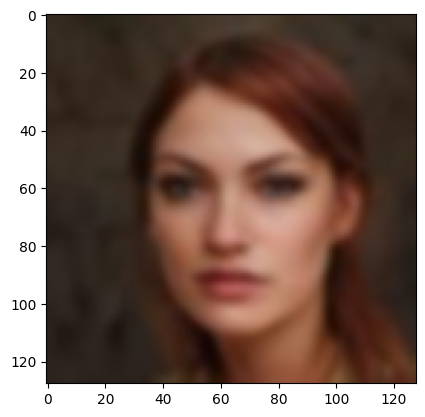

In [21]:
for x in test_image:
    plt.imshow(x)
    

In [22]:
prediction = autoencoder.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


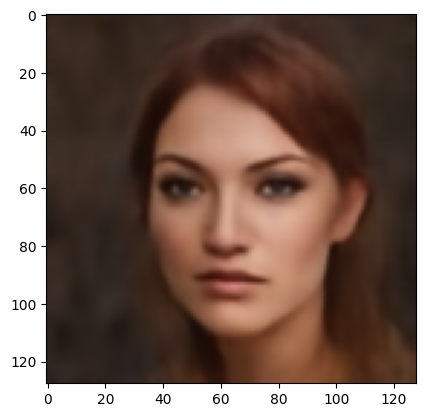

In [23]:
for x in prediction:
    plt.imshow(x)

In [24]:
#This model size is about 1.5 GB
autoencoder.save('/kaggle/working/model/autoencoder.h5')

In [26]:
!pip install tensorflow_model_optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.1 MB/s eta 0:00:00


In [37]:
model = tf.keras.models.load_model("/kaggle/working/model/autoencoder.h5", 
                                   custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
image = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


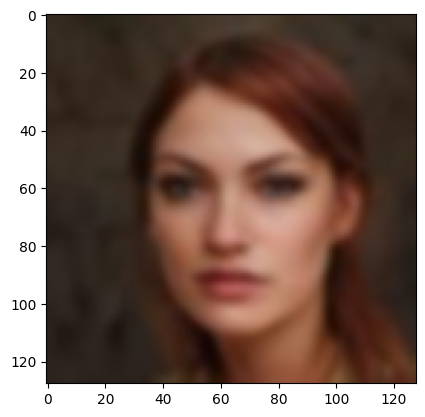

In [38]:
plt.imshow(test_image[0])

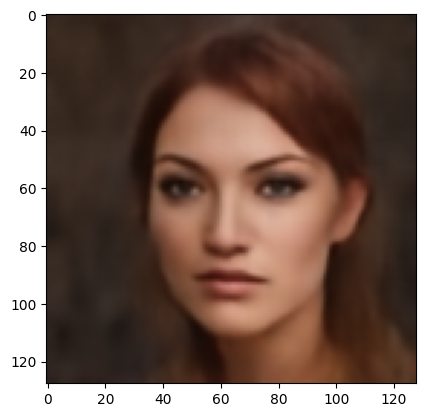

In [40]:
plt.imshow(image[0])